# Lab 1, Question 7b - Landsat-5 and 8

In [19]:
# Install the geemap package (only needs to be run once, uncomment below and run it the first time you run this notebook in a session).
# !pip install geemap

In [20]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    EE_PROJECT_ID = userdata.get('EE_PROJECT_ID') 
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()  # take environment variables
    EE_PROJECT_ID = os.getenv('EE_PROJECT_ID')

In [21]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project=EE_PROJECT_ID)
import geemap

### (7) Produce a table that describes the lowest amount of cloud cover (i.e. the amount of cloud cover in the image of the year with the lowest amount of cloud) per year for 2005, 2010 and 2015. Do this over a region of your choice, as a percentage. Provide a screenshot of your code that does so, in addition to your table. (5 pts)

### Use Landsat 5 and Landsat
Due to Landsat 7 ETM+ SLC-off data (https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data), the image is abnormal.


### Step 1: Get data

In [22]:
# Wellington International Airport
yearly_coordinates = [174.8076, -41.3270,]
yearly_point = ee.Geometry.Point(yearly_coordinates)

# maungatautari = ee.Geometry.Point([175.5698, -38.0281])
# `buffer(500)`: Returns the input buffered by a given distance.
#   If the distance is positive, the geometry is expanded,
#   and if the distance is negative, the geometry is contracted.
# `bounds()` Returns the bounding rectangle of the geometry.
yearly_region = yearly_point.buffer(500).bounds()

years = ['2005', '2010', '2015']
# sources = [ 'LE07', 'LE07', 'LE07']
sources = [ 'LT05', 'LT05', 'LC08']
bands = [
    ['SR_B3', 'SR_B2', 'SR_B1'],
    ['SR_B3', 'SR_B2', 'SR_B1'],
    ['SR_B4', 'SR_B3', 'SR_B2']
]


yearly_images = {}
yearly_masked_images= {}

for idx, year in enumerate(years):
  # Load the image with least cloud cover in `year`
  # The filtering step that is being applied here!
  # We are taking the first image in a sorted by cloud cover response.
  # The default `sort` is ascending
  year_image = ee.ImageCollection(f"LANDSAT/{sources[idx]}/C02/T1_L2") \
        .filterBounds(yearly_region) \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .sort("CLOUD_COVER") \
        .first()

  # Check metadata
  print(f'\nYear: {year}')
  print('Image ID:', year_image.get('LANDSAT_PRODUCT_ID').getInfo())
  # whole scene - the full Landsat tile, usually 185km × 185km)
  print('Cloud Cover (whole scene):', year_image.get('CLOUD_COVER').getInfo())

  yearly_images[year] = year_image
  yearly_masked_images[year] = mask_clouds(year_image)


Year: 2005
Image ID: LT05_L2SP_072089_20051108_20200901_02_T1
Cloud Cover (whole scene): 0

Year: 2010
Image ID: LT05_L2SP_073089_20100129_20200825_02_T1
Cloud Cover (whole scene): 1

Year: 2015
Image ID: LC08_L2SP_073089_20151010_20200908_02_T1
Cloud Cover (whole scene): 0.94


In [23]:
# Wellington International Airport
yearly_coordinates = [174.8076, -41.3270,]
yearly_point = ee.Geometry.Point(yearly_coordinates)

# maungatautari = ee.Geometry.Point([175.5698, -38.0281])
# `buffer(500)`: Returns the input buffered by a given distance.
#   If the distance is positive, the geometry is expanded,
#   and if the distance is negative, the geometry is contracted.
# `bounds()` Returns the bounding rectangle of the geometry.
yearly_region = yearly_point.buffer(500).bounds()

years = ['2005', '2010', '2015']
# sources = [ 'LE07', 'LE07', 'LE07']
sources = [ 'LT05', 'LT05', 'LC08']
bands = [
    ['SR_B3', 'SR_B2', 'SR_B1'],
    ['SR_B3', 'SR_B2', 'SR_B1'],
    ['SR_B4', 'SR_B3', 'SR_B2']
]


yearly_images = {}
yearly_masked_images= {}

for idx, year in enumerate(years):
  # Load the image with least cloud cover in `year`
  # The filtering step that is being applied here!
  # We are taking the first image in a sorted by cloud cover response.
  # The default `sort` is ascending
  year_image = ee.ImageCollection(f"LANDSAT/{sources[idx]}/C02/T1_L2") \
        .filterBounds(yearly_region) \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .sort("CLOUD_COVER") \
        .first()

  # Check metadata
  print(f'\nYear: {year}')
  print('Image ID:', year_image.get('LANDSAT_PRODUCT_ID').getInfo())
  # whole scene - the full Landsat tile, usually 185km × 185km)
  print('Cloud Cover (whole scene):', year_image.get('CLOUD_COVER').getInfo())

  yearly_images[year] = year_image
  yearly_masked_images[year] = mask_clouds(year_image)


Year: 2005
Image ID: LT05_L2SP_072089_20051108_20200901_02_T1
Cloud Cover (whole scene): 0

Year: 2010
Image ID: LT05_L2SP_073089_20100129_20200825_02_T1
Cloud Cover (whole scene): 1

Year: 2015
Image ID: LC08_L2SP_073089_20151010_20200908_02_T1
Cloud Cover (whole scene): 0.94


### Step 2: Focus to ROI

In [24]:
yearly_cloud_data = {}

# Count valid pixels before and after masking yearly
yearly_total_pixels = ee.Image.pixelArea().clip(
    yearly_region
  ).reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=yearly_region,
    scale=30,
    maxPixels=1e9
  ).getInfo()['area']

print(f"Total Pixels: {yearly_total_pixels}")

for idx, year in enumerate(years):
  band = bands[idx][0]
  yearly_valid_pixels = yearly_masked_images[year].select(band).reduceRegion(
      reducer=ee.Reducer.count(),
      geometry=yearly_region,
      scale=30,
      maxPixels=1e9
  ).getInfo()[band]

  yearly_cloud_coverage_pct = 100 * (1 - yearly_valid_pixels / yearly_total_pixels)
  print(f'\nyear: {year}')
  print(f"Valid (non-cloud) Pixels: {yearly_valid_pixels}")
  print(f"Estimated Cloud Coverage in ROI: {yearly_cloud_coverage_pct:.2f}%")
  yearly_cloud_data[year] = {
      'valid_pixels': yearly_valid_pixels,
      'cloud_coverage_pct': yearly_cloud_coverage_pct
  }


Total Pixels: 1496

year: 2005
Valid (non-cloud) Pixels: 1095
Estimated Cloud Coverage in ROI: 26.80%

year: 2010
Valid (non-cloud) Pixels: 1112
Estimated Cloud Coverage in ROI: 25.67%

year: 2015
Valid (non-cloud) Pixels: 1090
Estimated Cloud Coverage in ROI: 27.14%


### Step 3: Display data table

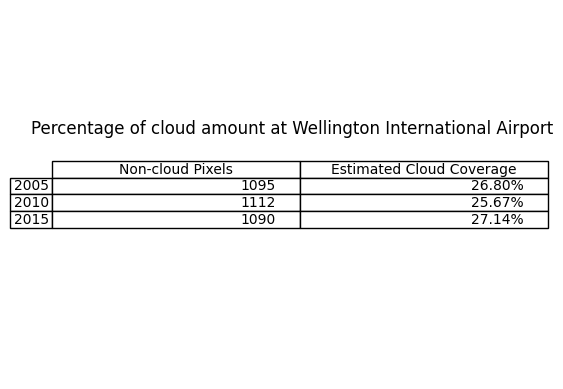

In [25]:
import matplotlib.pyplot as plt

# Display table
col_labels = ['Non-cloud Pixels', 'Estimated Cloud Coverage']
cell_text = []
for year in years:
  data = yearly_cloud_data[year]
  cell_text.append([
      data['valid_pixels'],
      f"{data['cloud_coverage_pct']:.2f}%"
  ])

fig, ax = plt.subplots()
ax.axis('off')
fig.suptitle('Percentage of cloud amount at Wellington International Airport', y=0.65)
ax.table(cellText=cell_text, rowLabels=years, colLabels=col_labels, loc='center')
fig.subplots_adjust()
plt.show()

### Extra step
Show the map to check

In [26]:
# Visualize the before and after
center = [yearly_coordinates[1], yearly_coordinates[0]]
yearly_maps = {
    '2005': geemap.Map(center=center, zoom=12),
    '2010': geemap.Map(center=center, zoom=12),
    '2015': geemap.Map(center=center, zoom=12),
}

for idx, year in enumerate(years):
  vis = {
    'bands': bands[idx],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
  }
  yearly_maps[year].addLayer(yearly_images[year], vis, 'Original Image (Cloudy)')
  yearly_maps[year].addLayer(yearly_masked_images[year], vis, 'Cloud Masked')


In [27]:
yearly_maps['2005']

Map(center=[-41.327, 174.8076], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

In [28]:
yearly_maps['2010']

Map(center=[-41.327, 174.8076], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

In [29]:
yearly_maps['2015']

Map(center=[-41.327, 174.8076], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…